In [1]:
#import dependency
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import requests
import psycopg2
import config as creds


In [2]:
def connect():
    
    # Set up a connection to the postgres server.
    conn_string = "host="+ creds.PGHOST +" port="+ "5432" +" dbname="+ creds.PGDATABASE +" user=" + creds.PGUSER \
                 +" password="+ creds.PGPASSWORD
    
    conn = psycopg2.connect(conn_string)
    #print("Connected!")

    #Create a cursor object
    cursor = conn.cursor()
    
    return conn, cursor


In [3]:
# Connecting to DB

conn, cursor = connect()

# SQL command to create inventory table
sql = "select * from ames;"
#cursor.execute(sql)
df = pd.read_sql_query(sql, conn)
#conn.commit()
# dat = pd.read_sql_query(sql, conn)

In [4]:
df

,ames_order,pid,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,526301100,20,RL,141.0,31770,Pave,NA,IR1,Lvl,...,0,NA,NA,NA,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NA,Reg,Lvl,...,0,NA,MnPrv,NA,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NA,IR1,Lvl,...,0,NA,NA,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NA,IR1,Lvl,...,0,NA,MnPrv,NA,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NA,IR1,Lvl,...,0,NA,GdPrv,NA,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NA,IR1,Low,...,0,NA,MnPrv,NA,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NA,Reg,Lvl,...,0,NA,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,77.0,10010,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,4,2006,WD,Normal,170000


# **Connect to AWS Database using spark**

# **Step 1: Data Exploration**
* Check the dataset
* check the missing values and duplicates
* check the columns
* check the types
* check the shape

In [5]:
df.dtypes

ames_order         int64
pid               object
mssubclass        object
mszoning          object
lotfrontage      float64
                  ...   
mosold             int64
yrsold             int64
saletype          object
salecondition     object
saleprice          int64
Length: 82, dtype: object

**Data Explorarion Summary:**
* There are multiple types of features, both categorical and numerical
* Tratget is numerical
* There are missing values in the dataset



# **Step 2: Feature Selection:**
* Use heatmap to identify features that are most correlated to the Sales Price


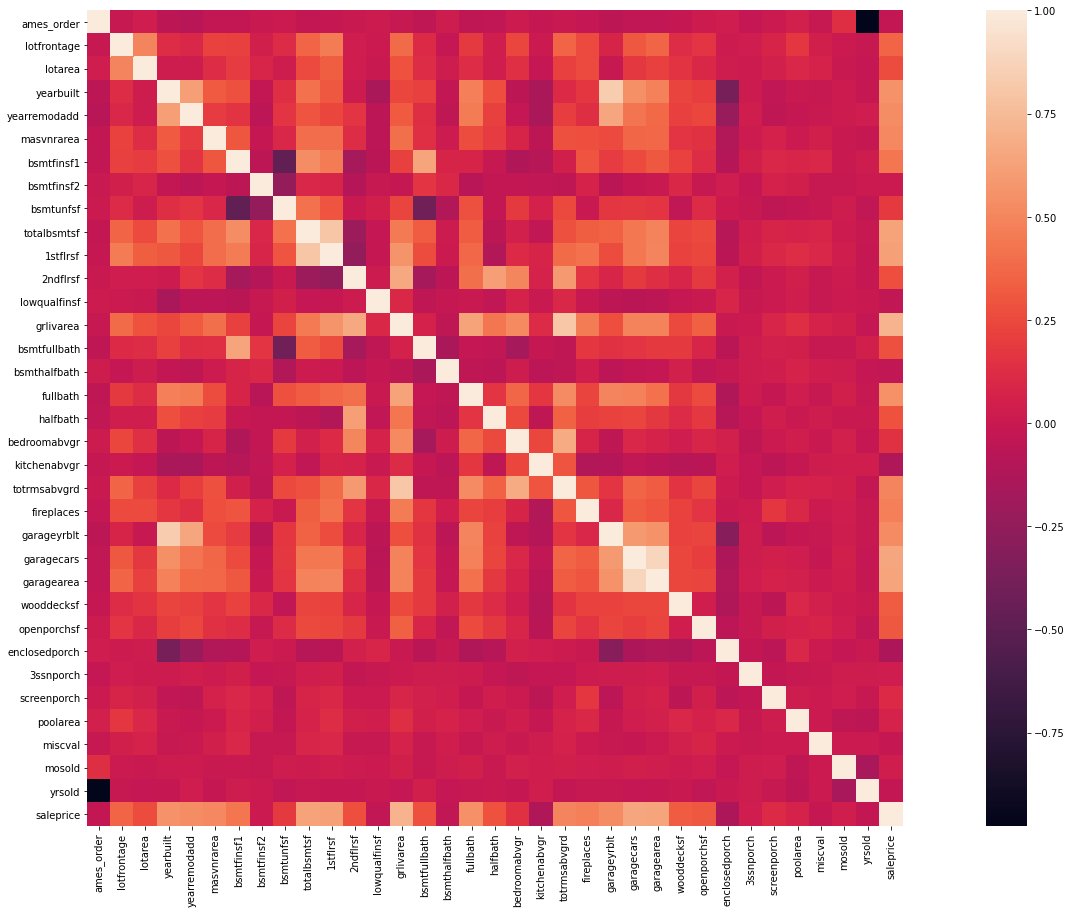

In [6]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(30, 15))
sns.heatmap(corrmat, vmax=1, square=True)


In [7]:
corrmat_2 = corrmat['saleprice'].sort_values(ascending=False).head(12).to_frame()

cm = sns.light_palette("purple", as_cmap=True)

corrmat_3 = corrmat_2.style.background_gradient(cmap=cm)
corrmat_3


,saleprice
saleprice,1.000000
grlivarea,0.706780
garagecars,0.647877
garagearea,0.640401
totalbsmtsf,0.632280
1stflrsf,0.621676
yearbuilt,0.558426
fullbath,0.545604
yearremodadd,0.532974
garageyrblt,0.526965


# **Initial Features Selection**
we selected 15 features.

***NUmerical Category:***
Based on heatmap, pick the top 11 features that are most correlated to sales price(vmax>0.5)

* overallqual_id
* grlivarea	
* garagecars
* garagearea
* totalbsmtsf	
* 1stflrsf
* fullbath	
* totrmsabvgrd
* yearbuilt	
* yearremodadd

***Categorical Category:***
Categorical object can not be compared using heatmap so we selected a few more features based on commonsense
* LotConfig
* Neighborhood
* BldgType
* Foundation
Noted: we will try different combination to determine the final features selected in machine learning step


# **Step 3: Data cleaning:**

* remove null value or replace it with the mode of their respective columns
* remove duplicate if any
* create new feature to combine features that are in the same category


In [8]:
# combine train and test dataset
df.shape[0]
df.columns


Index(['ames_order', 'pid', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea',
       'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecon

In [9]:
#check missing data ratio
missing_2 = (df.isnull().sum()/ len(df)) * 100
missing_2 = missing_2.drop(missing_2[missing_2 ==0].index).sort_values(ascending=False)[:30]
missing_2

lotfrontage     16.723549
garageyrblt      5.426621
masvnrarea       0.784983
masvnrtype       0.784983
bsmthalfbath     0.068259
bsmtfullbath     0.068259
garagearea       0.034130
garagecars       0.034130
electrical       0.034130
totalbsmtsf      0.034130
bsmtunfsf        0.034130
bsmtfinsf2       0.034130
bsmtfinsf1       0.034130
dtype: float64

**remove/replace NA**


In [10]:
#Replace null values with o for garageyrblt, garagearea and garagecars with 0
for col in ('garageyrblt', 'garagearea', 'garagecars'):
  df[col] = df[col].fillna(0)

In [11]:
#Fill missing values in masvnrarea and masvnrtype with mode
df['masvnrarea'].value_counts()
df['masvnrarea'] = df['masvnrarea'].fillna(df['masvnrarea'].mode()[0])
df['masvnrtype'].value_counts()
df['masvnrtype'] = df['masvnrtype'].fillna(df['masvnrtype'].mode()[0])

In [12]:
df['bsmthalfbath'].value_counts()
df['bsmthalfbath'] = df['bsmthalfbath'].fillna(df['bsmthalfbath'].mode()[0])
df['bsmtfullbath'].value_counts()
df['bsmtfullbath'] = df['bsmtfullbath'].fillna(df['bsmtfullbath'].mode()[0])

In [13]:
# null values saleprice are due to missing saleprice column in the test dataset
# we will replace missing values in lotfrontage with median lotfrontage of neighberhood 
df['lotfrontage'] = df.groupby('neighborhood')['lotfrontage'].transform(
      lambda x: x.fillna(x.median()))

In [14]:
df["utilities"].value_counts()
# drop the entire column since it only doesn't help with prediction
df = df.drop(['utilities'], axis=1)

In [15]:
df["electrical"].value_counts()
df["electrical"] = df["electrical"].fillna(df["electrical"].mode()[0])

In [16]:
basement = ["totalbsmtsf", "bsmtunfsf", "bsmtfinsf2", "bsmtfinsf1"]
for i in basement:
  print(df[i].value_counts())
  df[i] = df[i].fillna(df[i].mode()[0])

0.0       79
864.0     74
672.0     29
912.0     26
1040.0    25
          ..
811.0      1
1958.0     1
1615.0     1
1765.0     1
1967.0     1
Name: totalbsmtsf, Length: 1058, dtype: int64
0.0       244
384.0      19
728.0      14
672.0      13
600.0      12
         ... 
1380.0      1
439.0       1
227.0       1
303.0       1
1851.0      1
Name: bsmtunfsf, Length: 1137, dtype: int64
0.0      2578
294.0       5
180.0       5
72.0        3
435.0       3
         ... 
35.0        1
154.0       1
106.0       1
488.0       1
530.0       1
Name: bsmtfinsf2, Length: 274, dtype: int64
0.0       930
24.0       27
16.0       14
300.0       9
288.0       8
         ... 
914.0       1
1836.0      1
874.0       1
337.0       1
696.0       1
Name: bsmtfinsf1, Length: 995, dtype: int64


In [17]:
#Check if there is any duplicates
df.duplicated().sum()

0

In [18]:
# combine an important feature - total_area
df['total_area'] = df['totalbsmtsf'] + df['1stflrsf'] + df['2ndflrsf'] + df['grlivarea'] + df['garagearea']


In [19]:
#check if the new column was addedd
df

,ames_order,pid,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,...,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,total_area
0,1,526301100,20,RL,141.0,31770,Pave,NA,IR1,Lvl,...,NA,NA,NA,0,5,2010,WD,Normal,215000,4920.0
1,2,526350040,20,RH,80.0,11622,Pave,NA,Reg,Lvl,...,NA,MnPrv,NA,0,6,2010,WD,Normal,105000,3404.0
2,3,526351010,20,RL,81.0,14267,Pave,NA,IR1,Lvl,...,NA,NA,Gar2,12500,6,2010,WD,Normal,172000,4299.0
3,4,526353030,20,RL,93.0,11160,Pave,NA,Reg,Lvl,...,NA,NA,NA,0,4,2010,WD,Normal,244000,6852.0
4,5,527105010,60,RL,74.0,13830,Pave,NA,IR1,Lvl,...,NA,MnPrv,NA,0,3,2010,WD,Normal,189900,4668.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NA,IR1,Lvl,...,NA,GdPrv,NA,0,3,2006,WD,Normal,142500,3597.0
2926,2927,923276100,20,RL,74.0,8885,Pave,NA,IR1,Low,...,NA,MnPrv,NA,0,6,2006,WD,Normal,131000,3152.0
2927,2928,923400125,85,RL,62.0,10441,Pave,NA,Reg,Lvl,...,NA,MnPrv,Shed,700,7,2006,WD,Normal,132000,2852.0
2928,2929,924100070,20,RL,77.0,10010,Pave,NA,Reg,Lvl,...,NA,NA,NA,0,4,2006,WD,Normal,170000,4585.0


In [20]:
numerical = df.select_dtypes(exclude='object')
numerical.columns

Index(['ames_order', 'lotfrontage', 'lotarea', 'yearbuilt', 'yearremodadd',
       'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf',
       '1stflrsf', '2ndflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath',
       'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr',
       'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars', 'garagearea',
       'wooddecksf', 'openporchsf', 'enclosedporch', '3ssnporch',
       'screenporch', 'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice',
       'total_area'],
      dtype='object')

In [21]:
categorical = df.select_dtypes('object')
categorical.columns

Index(['pid', 'mssubclass', 'mszoning', 'street', 'alley', 'lotshape',
       'landcontour', 'lotconfig', 'landslope', 'neighborhood', 'condition1',
       'condition2', 'bldgtype', 'housestyle', 'overallqual', 'overallcond',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond',
       'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc',
       'centralair', 'electrical', 'kitchenqual', 'functional', 'fireplacequ',
       'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'paveddrive',
       'poolqc', 'fence', 'miscfeature', 'saletype', 'salecondition'],
      dtype='object')

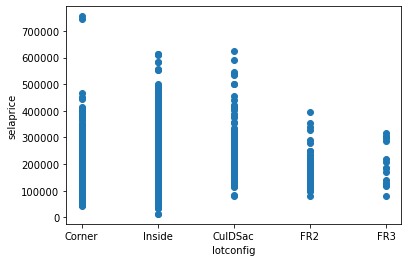

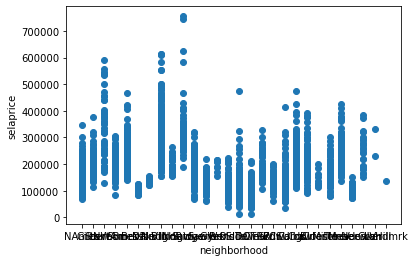

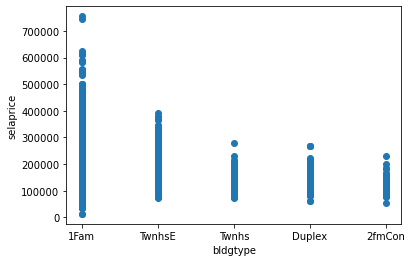

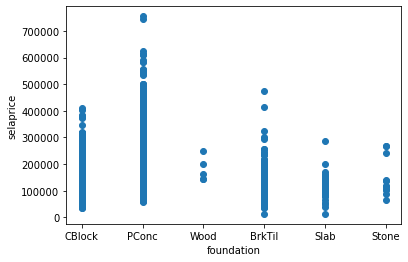

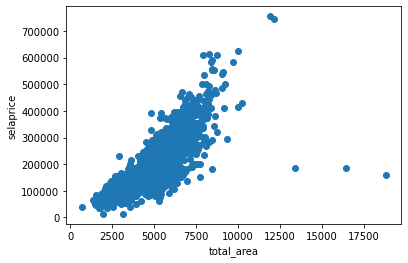

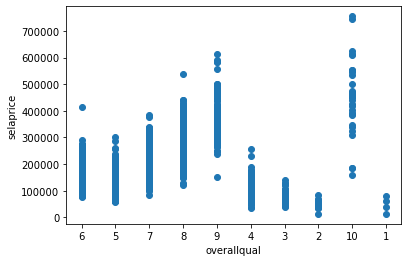

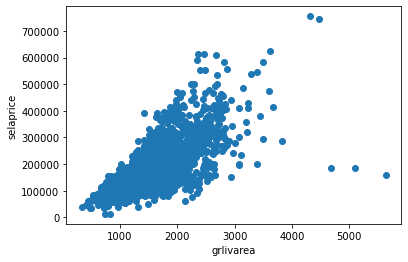

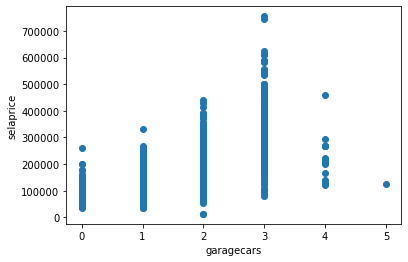

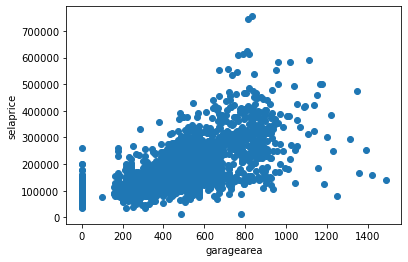

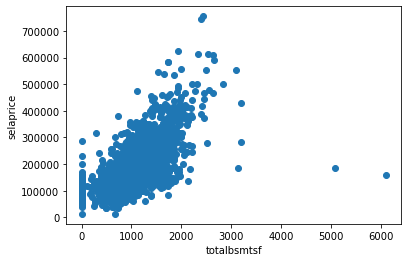

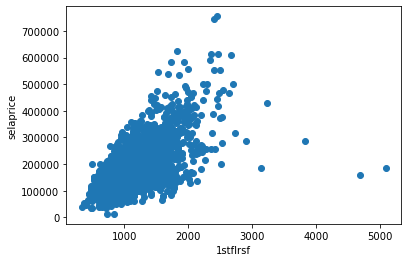

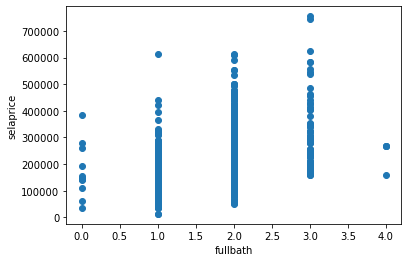

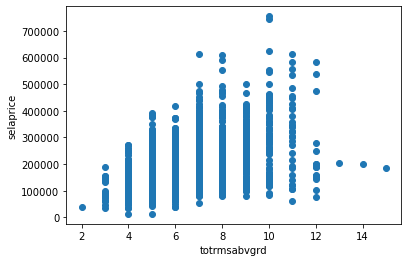

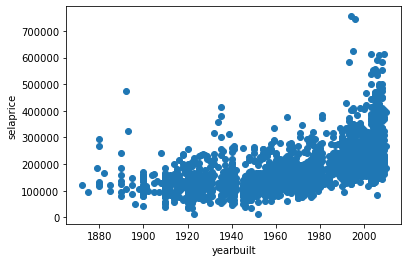

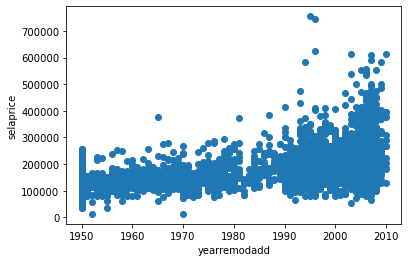

In [22]:
x_features = ["lotconfig", "neighborhood", "bldgtype", "foundation","total_area","overallqual","grlivarea", "garagecars","garagearea","totalbsmtsf","1stflrsf","fullbath","totrmsabvgrd", "yearbuilt","yearremodadd"]
for x in x_features:

  plt.scatter(df[x], df['saleprice'])
  plt.xlabel(x)
  plt.ylabel('selaprice')
  plt.show()

In [23]:
#dropping any NA before putting the dataset into our model
df = df.dropna()
df.isnull().sum()

ames_order       0
pid              0
mssubclass       0
mszoning         0
lotfrontage      0
                ..
yrsold           0
saletype         0
salecondition    0
saleprice        0
total_area       0
Length: 82, dtype: int64

Export cleaned dataset

In [24]:
df.to_csv('cleaned_dataset', index=False)